In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi, _ = obs[1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax): 
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)

def draw(xs, zlist, edges): #edges追加
    ax = make_ax()
    draw_trajectory(xs, ax)
    draw_observations(xs, zlist, ax)
    draw_edges(edges, ax)
    plt.show()

In [3]:
def read_data():#データの読み込み
    hat_xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
    zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）

    with open("log.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": #姿勢のレコードの場合
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": #センサ値のレコードの場合
                if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
                
        return hat_xs, zlist

In [4]:
class Edge: ###graphbasedslam3edge
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]): #sensor_noise_rate追加
        assert z1[0] == z2[0] #ランドマークのIDが違ったら処理を止める
            
        self.landmark_id = z1[0]
        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.x1, self.x2 = xs[t1], xs[t2]    #各時刻の姿勢
        self.z1, self.z2 = z1[1], z2[1]     #各時刻のセンサ値
        
        ##精度行列の作成##
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        s1 = math.sin(self.x1[2] + self.z1[1])
        c1 = math.cos(self.x1[2] + self.z1[1])
        R1 = np.array([[-c1,  self.z1[0]*s1,  0],
                                   [-s1, -self.z1[0]*c1, 0],
                                   [   0,                      1, -1]])
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                                  [s2, self.z2[0]*c2,   0],
                                  [  0,                   -1,  1]])
        
        self.Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        self.Omega = np.linalg.inv(self.Sigma)
        
    def __str__(self): #オブジェクトをprintすると呼ばれるメソッド
        return "landmark:{}, x1:{}, x2:{}, z1:{}, z2:{}, \nΣ:{}".format(self.landmark_id, self.x1, self.x2, self.z1, self.z2, self.Sigma) 

In [5]:
import itertools 
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {} #ランドマークのIDをキーにして観測された時刻とセンサ値を記録 

    for step in zlist:           #キーを時刻からランドマークのIDへ
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) #時刻のペアを作成
        edges += [Edge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges

<IPython.core.display.Javascript object>


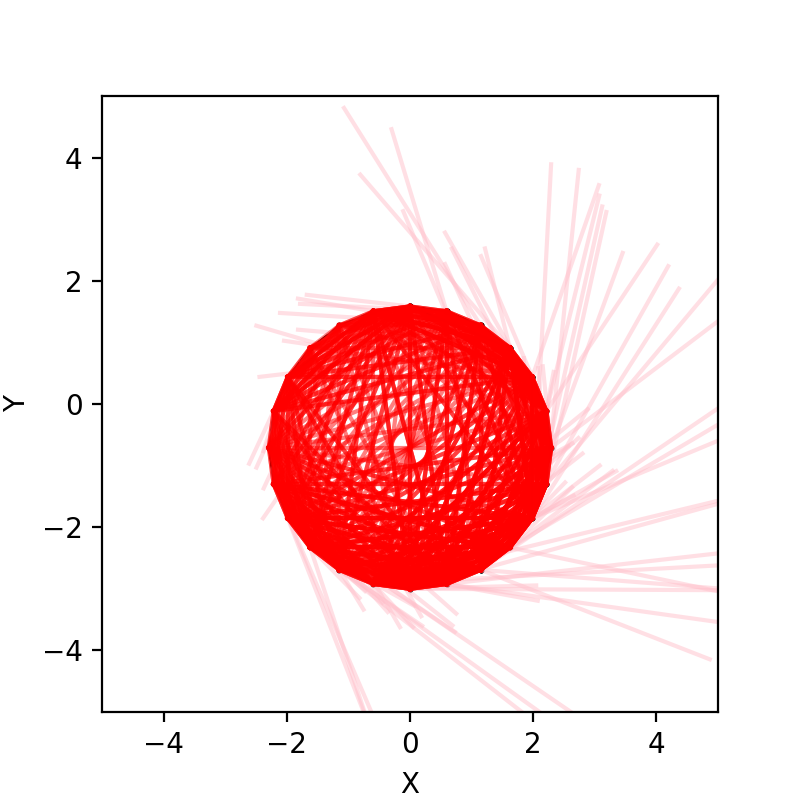

In [6]:
hat_xs, zlist = read_data() 
edges = make_edges(hat_xs, zlist)
draw(hat_xs, zlist, edges)

In [7]:
for e in edges:
    print(e)

landmark:1, x1:[ 0. -3.  0.], x2:[ 0.59316956 -2.92190775  0.26179939], z1:[2.04935933 0.02679605 3.07700971], z2:[ 1.50536558 -0.44356591  3.05020716], 
Σ:[[ 0.12541578 -0.00496595 -0.00054303]
 [-0.00496595  0.0174828  -0.00882297]
 [-0.00054303 -0.00882297  0.01      ]]
landmark:1, x1:[ 0. -3.  0.], x2:[-1.98478402  0.43774677  4.1887902 ], z1:[2.04935933 0.02679605 3.07700971], z2:[4.44677759 1.0323746  2.997741  ], 
Σ:[[ 0.21193083 -0.14192213 -0.00957162]
 [-0.14192213  0.31788804 -0.01053672]
 [-0.00957162 -0.01053672  0.01      ]]
landmark:1, x1:[ 0. -3.  0.], x2:[-2.21373893 -0.11499926  4.45058959], z1:[2.04935933 0.02679605 3.07700971], z2:[4.06325811 0.79095854 3.14526744], 
Σ:[[ 0.19548551 -0.12110289 -0.00863156]
 [-0.12110289  0.26220417 -0.01024947]
 [-0.00863156 -0.01024947  0.01      ]]
landmark:1, x1:[ 0. -3.  0.], x2:[-2.29183118 -0.70816882  4.71238898], z1:[2.04935933 0.02679605 3.07700971], z2:[ 3.11933403  0.63392647 -3.02607918], 
Σ:[[ 0.16496596 -0.07748165 -0

 [ 0.00164288 -0.00802024  0.01      ]]
landmark:4, x1:[ 0.59316956 -2.92190775  6.54498469], x2:[-1.14591559 -2.69295284 12.04277184], z1:[ 2.21139615  0.54864859 -1.11189813], z2:[ 1.62126649 -0.0704062  -1.09754702], 
Σ:[[ 0.0893827   0.02091213  0.00173743]
 [ 0.02091213  0.07678229 -0.00716897]
 [ 0.00173743 -0.00716897  0.01      ]]
landmark:4, x1:[ 0.59316956 -2.92190775  6.54498469], x2:[-0.59316956 -2.92190775 12.30457123], z1:[ 2.21139615  0.54864859 -1.11189813], z2:[ 0.94836976 -0.56426913 -1.29332103], 
Σ:[[ 0.06125725  0.03409488  0.00226265]
 [ 0.03409488  0.06669464 -0.00541704]
 [ 0.00226265 -0.00541704  0.01      ]]
landmark:4, x1:[ 1.14591559 -2.69295284  6.80678408], x2:[ 1.62056937 -2.32873819  7.06858347], z1:[ 1.97377757  0.27854409 -0.98734976], z2:[ 1.40421896 -0.01736905 -0.87533023], 
Σ:[[ 0.06430754  0.05013938  0.00598596]
 [ 0.05013938  0.06536705 -0.00595534]
 [ 0.00598596 -0.00595534  0.01      ]]
landmark:4, x1:[ 1.14591559 -2.69295284  6.80678408], x2:

 [ 0.01098697 -0.01539015  0.01      ]]
landmark:0, x1:[ 2.21373893 -1.30133838  7.59218225], x2:[ 0.59316956 -2.92190775 12.82817   ], z1:[ 4.52376188  0.04492456 -0.25284867], z2:[ 5.29203666 -0.40101016 -0.33151655], 
Σ:[[ 0.60705374  0.00772648  0.00920865]
 [ 0.00772648  0.46413488 -0.01553564]
 [ 0.00920865 -0.01553564  0.01      ]]
landmark:0, x1:[ 2.21373893 -1.30133838  7.59218225], x2:[ 1.14591559 -2.69295284 13.08996939], z1:[ 4.52376188  0.04492456 -0.25284867], z2:[ 3.99356051 -0.89564149 -0.48692888], 
Σ:[[ 0.34391623 -0.01882039  0.00741514]
 [-0.01882039  0.4608099  -0.01173441]
 [ 0.00741514 -0.01173441  0.01      ]]
landmark:0, x1:[ 2.29183118 -0.70816882  7.85398163], x2:[ 2.21373893 -0.11499926  8.11578102], z1:[ 3.36722273 -0.35183481 -0.34105044], z2:[ 3.24663838 -0.84950132 -0.28946345], 
Σ:[[ 0.13313342  0.14589238  0.01465715]
 [ 0.14589238  0.35038915 -0.00740128]
 [ 0.01465715 -0.00740128  0.01      ]]
landmark:0, x1:[ 2.29183118 -0.70816882  7.85398163], x2: